In [4]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

# Data Preparation

In [5]:
df = pd.read_csv('CreditScoring.csv')

In [6]:
df.columns = df.columns.str.lower()
df.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
4,1,0,1,36,26,1,1,1,46,107,0,0,310,910


In [7]:
status_values = {
    1: 'ok',
    2: 'default',
    3: 'unknown'
}

home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}

marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}

records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}

job_values = {
    1: 'fixed',
    2: 'partime',
    3: 'freelance',
    4: 'others',
    0: 'unk'
}

df.status = df.status.map(status_values)
df.home = df.home.map(home_values)
df.marital = df.marital.map(marital_values)
df.records = df.records.map(records_values)
df.job = df.job.map(job_values)
df.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,ok,9,rent,60,30,married,no,freelance,73,129,0,0,800,846
1,ok,17,rent,60,58,widow,no,fixed,48,131,0,0,1000,1658
2,default,10,owner,36,46,married,yes,freelance,90,200,3000,0,2000,2985
3,ok,0,rent,60,24,single,no,fixed,63,182,2500,0,900,1325
4,ok,0,rent,36,26,single,no,fixed,46,107,0,0,310,910


In [8]:
df.describe().round()
for c in ['income', 'assets', 'debt']:
    df[c] = df[c].replace(to_replace=99999999, value=np.nan)
df.describe().round()

,seniority,time,age,expenses,income,assets,debt,amount,price
count,4455.0,4455.0,4455.0,4455.0,4421.0,4408.0,4437.0,4455.0,4455.0
mean,8.0,46.0,37.0,56.0,131.0,5403.0,343.0,1039.0,1463.0
std,8.0,15.0,11.0,20.0,86.0,11573.0,1246.0,475.0,628.0
min,0.0,6.0,18.0,35.0,0.0,0.0,0.0,100.0,105.0
25%,2.0,36.0,28.0,35.0,80.0,0.0,0.0,700.0,1118.0
50%,5.0,48.0,36.0,51.0,120.0,3000.0,0.0,1000.0,1400.0
75%,12.0,60.0,45.0,72.0,165.0,6000.0,0.0,1300.0,1692.0
max,48.0,72.0,68.0,180.0,959.0,300000.0,30000.0,5000.0,11140.0


In [9]:
df.status.value_counts()

status
ok         3200
default    1254
Name: count, dtype: int64

In [10]:
df = df[df.status != 'unknown']

In [11]:
df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=11)
df_train, df_val = train_test_split(df, test_size=0.25, random_state=11)

y_train = (df_train.status == 'default').values
y_val = (df_val.status == 'default').values
y_test = (df_test.status == 'default').values

del df_train['status']
del df_val['status']
df_test_features = df_test.copy()
del df_test_features['status']

In [12]:
df_train = df_train.fillna(0)
df_val = df_val.fillna(0)

In [13]:
dict_train = df_train.fillna(0).to_dict(orient='records')
dict_val = df_val.fillna(0).to_dict(orient='records')
dict_test = df_test_features.fillna(0).to_dict(orient='records')

In [14]:
dv = DictVectorizer(sparse=False)

X_train = dv.fit_transform(dict_train)
X_val = dv.transform(dict_val)
X_test = dv.transform(dict_test)

# Decission Tree

`Decision Tree` используется как простая и интерпретируемая
базовая модель для оценки сложности задачи
и выявления переобучения.

In [15]:
from sklearn.tree import DecisionTreeClassifier

In [16]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [17]:
y_pred = dt.predict_proba(X_train)[:,1]
roc_auc_score(y_train, y_pred)

1.0

In [19]:
y_pred = dt.predict_proba(X_val)[:,1]
roc_auc_score(y_val, y_pred)

0.6365033475941232

Модель демонстрирует практически идеальное качество
на обучающей выборке и значительно худшее — на валидационной,
что указывает на `сильное переобучение`.


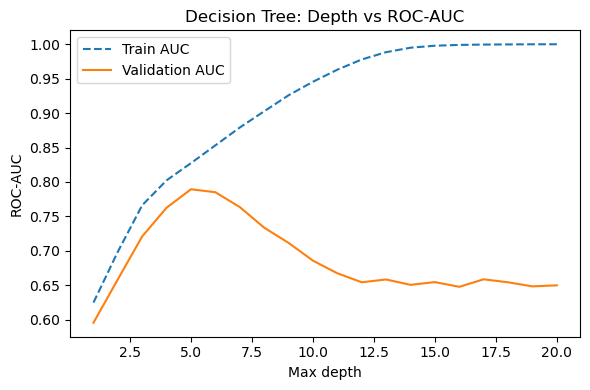

In [20]:
depths = range(1, 21)

train_auc = []
val_auc = []

for d in depths:
    dt = DecisionTreeClassifier(
        max_depth=d,
        random_state=1
    )
    dt.fit(X_train, y_train)

    train_auc.append(
        roc_auc_score(y_train, dt.predict_proba(X_train)[:, 1])
    )
    val_auc.append(
        roc_auc_score(y_val, dt.predict_proba(X_val)[:, 1])
    )

plt.figure(figsize=(6, 4))

plt.plot(depths, train_auc, label='Train AUC', linestyle='dashed')
plt.plot(depths, val_auc, label='Validation AUC')

plt.xlabel('Max depth')
plt.ylabel('ROC-AUC')
plt.title('Decision Tree: Depth vs ROC-AUC')
plt.legend()
plt.tight_layout()
plt.show()

При увеличении глубины дерева качество на обучающей выборке
монотонно растёт, тогда как валидационная метрика достигает
максимума при ограниченной глубине.

Это отражает классический эффект переобучения
и необходимость контроля сложности модели.

Дополнительно рассмотрим влияние параметра `min_samples_leaf`,
который ограничивает минимальное количество объектов в листе
и способствует сглаживанию решений.

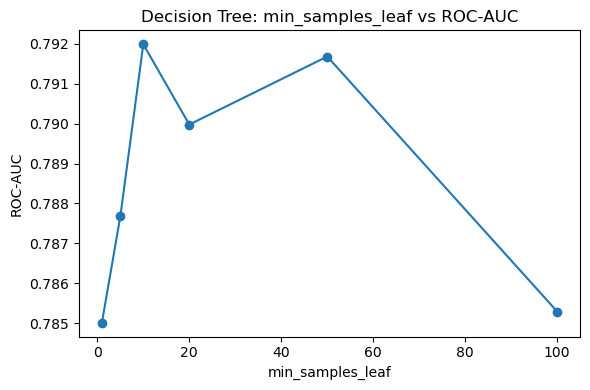

In [21]:
leaves = [1, 5, 10, 20, 50, 100]
val_auc = []

for m in leaves:
    dt = DecisionTreeClassifier(
        max_depth=6,
        min_samples_leaf=m,
        random_state=1
    )
    dt.fit(X_train, y_train)

    val_auc.append(
        roc_auc_score(y_val, dt.predict_proba(X_val)[:, 1])
    )

plt.figure(figsize=(6, 4))

plt.plot(leaves, val_auc, marker='o')
plt.xlabel('min_samples_leaf')
plt.ylabel('ROC-AUC')
plt.title('Decision Tree: min_samples_leaf vs ROC-AUC')
plt.tight_layout()
plt.show()

Увеличение значения `min_samples_leaf` действует как регуляризация,
снижая переобучение за счёт более обобщённых разбиений.

Оптимальное значение выбирается как компромисс
между устойчивостью модели и качеством на валидационной выборке.

После ограничения глубины дерева и минимального размера листа
удалось снизить переобучение, однако качество модели
остаётся ограниченным.


In [22]:
dt = DecisionTreeClassifier(max_depth=6, min_samples_leaf=10)
dt.fit(X_train, y_train)

y_pred_dt = dt.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred_dt)

0.7929193429933669

Decision Tree позволяет выявить структуру данных
и наглядно продемонстрировать проблему переобучения,
однако его обобщающая способность ограничена.

# Random Forest
Random Forest используется для снижения переобучения,
наблюдаемого в одиночном дереве решений,
за счёт ансамблирования нескольких моделей.

In [23]:
from sklearn.ensemble import RandomForestClassifier

In [24]:
rf = RandomForestClassifier(n_estimators=10, random_state=3)
rf.fit(X_train, y_train)

y_pred = rf.predict_proba(X_val)[:,1]
roc_auc_score(y_val, y_pred)

0.7898456959226576

В качестве отправной точки используется Random Forest
с небольшим числом деревьев.


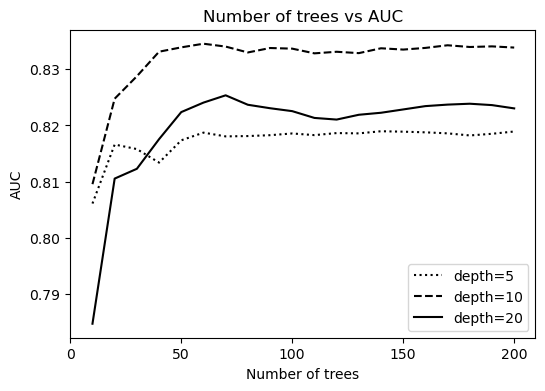

In [25]:
all_aucs = {}

for depth in [5, 10, 20]:
    aucs = []

    for i in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=i, max_depth=depth, random_state=1)
        rf.fit(X_train, y_train)
        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        aucs.append(auc)
    
    all_aucs[depth] = aucs
    print()

plt.figure(figsize=(6, 4))
num_trees = list(range(10, 201, 10))
plt.plot(num_trees, all_aucs[5], label='depth=5', color='black', linestyle='dotted')
plt.plot(num_trees, all_aucs[10], label='depth=10', color='black', linestyle='dashed')
plt.plot(num_trees, all_aucs[20], label='depth=20', color='black', linestyle='solid')
plt.xticks(range(0, 201, 50))
plt.legend()
plt.title('Number of trees vs AUC')
plt.xlabel('Number of trees')
plt.ylabel('AUC')
plt.show()

Увеличение числа деревьев улучшает качество
до определённого момента, после чего эффект
становится незначительным.

min_samples_leaf: 3
10 -> 0.823
30 -> 0.831
50 -> 0.833
70 -> 0.835
90 -> 0.833
110 -> 0.834
130 -> 0.834
150 -> 0.835
170 -> 0.835
190 -> 0.834

min_samples_leaf: 5
10 -> 0.823
30 -> 0.832
50 -> 0.832
70 -> 0.832
90 -> 0.833
110 -> 0.833
130 -> 0.833
150 -> 0.834
170 -> 0.835
190 -> 0.835

min_samples_leaf: 10
10 -> 0.827
30 -> 0.832
50 -> 0.834
70 -> 0.834
90 -> 0.835
110 -> 0.835
130 -> 0.835
150 -> 0.835
170 -> 0.835
190 -> 0.835



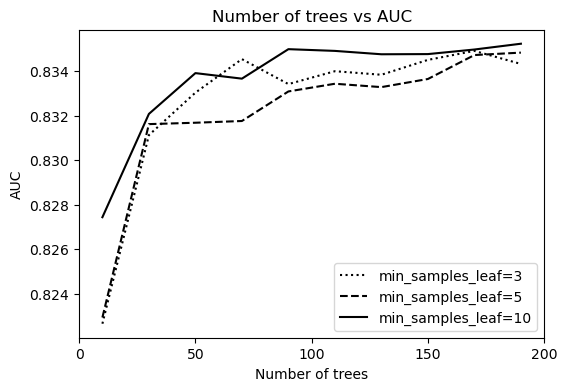

In [26]:
all_aucs = {}

for m in [3, 5, 10]:
    print('min_samples_leaf: %s' % m)
    aucs = []

    for i in range(10, 201, 20):
        rf = RandomForestClassifier(n_estimators=i, max_depth=10, min_samples_leaf=m, random_state=1)
        rf.fit(X_train, y_train)
        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        print('%s -> %.3f' % (i, auc))
        aucs.append(auc)
    
    all_aucs[m] = aucs
    print()

plt.figure(figsize=(6, 4))
num_trees = list(range(10, 201, 20))
plt.plot(num_trees, all_aucs[3], label='min_samples_leaf=3', color='black', linestyle='dotted')
plt.plot(num_trees, all_aucs[5], label='min_samples_leaf=5', color='black', linestyle='dashed')
plt.plot(num_trees, all_aucs[10], label='min_samples_leaf=10', color='black', linestyle='solid')
plt.xticks(range(0, 201, 50))
plt.legend()
plt.title('Number of trees vs AUC')
plt.xlabel('Number of trees')
plt.ylabel('AUC')
plt.show()

Параметр `min_samples_leaf` контролирует минимальное количество объектов
в листе дерева и выступает в роли регуляризации.

При слишком малых значениях модель склонна к переобучению,
в то время как увеличение `min_samples_leaf` делает предсказания
более устойчивыми за счёт сглаживания решений.

На основании валидационной ROC-AUC был выбран компромиссный вариант,
обеспечивающий стабильное качество без существенной потери точности.


In [27]:
rf = RandomForestClassifier(n_estimators=200, max_depth=10, min_samples_leaf=5, random_state=1)
rf.fit(X_train, y_train)


y_pred_rf = rf.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred_rf)

0.8349051288328302

Random Forest значительно превосходит одиночное дерево
и демонстрирует устойчивое качество.


# XGBoost

Градиентный бустинг выбран как финальная модель
благодаря высокой эффективности на табличных данных
и способности моделировать сложные нелинейные зависимости.

In [28]:
import xgboost as xgb

In [29]:
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=dv.feature_names_)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=dv.feature_names_)

Для оценки качества используем **ROC-AUC** (не зависит от порога и устойчивее, чем accuracy при дисбалансе).

Валидация применяется для:
- **early stopping** (выбор оптимального числа деревьев),
- подбора ключевых гиперпараметров без утечки информации с теста.

In [31]:
n_pos = (y_train == 1).sum()
n_neg = (y_train == 0).sum()
scale_pos_weight = n_neg / max(n_pos, 1)
print(scale_pos_weight)

xgb_params = {
    'eta': 0.05, 
    'max_depth': 4, 
    'min_child_weight': 1, 
    'objective': 'binary:logistic', 
    'eval_metric': 'auc', 
    'seed': 1, 
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'scale_pos_weight': float(scale_pos_weight)
} 

watchlist = [(dtrain, 'train'), (dval, 'val')]

2.6040992448759437


[0]	train-auc:0.77597	val-auc:0.72494
[171]	train-auc:0.92960	val-auc:0.84130
Best iteration: 121
Best validation AUC (from training): 0.8417
Validation AUC (sklearn): 0.8417


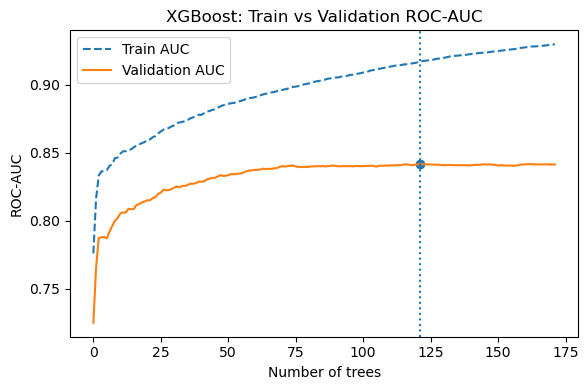

In [36]:
evals_result = {}

model = xgb.train(
    params=xgb_params,
    dtrain=dtrain,
    num_boost_round=3000,
    evals=watchlist,
    early_stopping_rounds=50,
    evals_result=evals_result,
    verbose_eval=200
)

best_iter = model.best_iteration
best_auc = model.best_score

y_pred_val = model.predict(dval, iteration_range=(0, best_iter + 1))
val_auc = roc_auc_score(y_val, y_pred_val)

print(f'Best iteration: {best_iter}')
print(f'Best validation AUC (from training): {best_auc:.4f}')
print(f'Validation AUC (sklearn): {val_auc:.4f}')

train_auc = evals_result['train']['auc']
val_auc = evals_result['val']['auc']
trees = range(len(train_auc))

best_iter = int(np.argmax(val_auc))
best_auc = val_auc[best_iter]


plt.figure(figsize=(6, 4))
plt.plot(trees, train_auc, label='Train AUC', linestyle='dashed')
plt.plot(trees, val_auc, label='Validation AUC')
plt.axvline(best_iter, linestyle='dotted')
plt.scatter(best_iter, best_auc)
plt.xlabel('Number of trees')
plt.ylabel('ROC-AUC')
plt.title('XGBoost: Train vs Validation ROC-AUC')
plt.legend()
plt.tight_layout()
plt.show()

**Что мы проверяем на графике:**

- если **Train AUC** продолжает расти, а **Val AUC** перестаёт улучшаться — начинается *переобучение*;
- *early stopping* фиксирует оптимальное число деревьев и предотвращает деградацию качества;
- параметры subsample, colsample_bytree, а также регуляризация (lambda, alpha) помогают повысить устойчивость.

**Почему такие гиперпараметры:**

- `eta=0.05` + много деревьев + early stopping: более стабильное обучение, меньше шанс переобучения.
- `max_depth=4` и `subsample/colsample_bytree` ограничивает сложность и добавляет «шумоустойчивость».
- `scale_pos_weight` компенсирует дисбаланс, чтобы модель не игнорировала редкий класс дефолта.



In [39]:
final_model = model
y_pred_xgb = y_pred_val

In [40]:
y_pred_xgb = final_model.predict(dval)
roc_auc_score(y_val, y_pred_xgb)

0.8412972267232435

XGBoost показал наилучшее качество среди всех протестированных моделей
(ROC-AUC = 0.83 на валидационной выборке) и был выбран
в качестве финального решения для задачи кредитного скоринга.

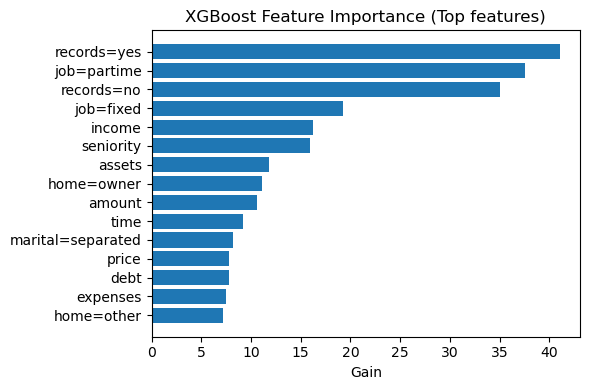

In [41]:
importance = final_model.get_score(importance_type='gain')

df_importance = (
    pd.DataFrame(importance.items(), columns=['feature', 'gain'])
      .sort_values(by='gain', ascending=True)
)

top_n = 15
df_importance = df_importance.tail(top_n)

plt.figure(figsize=(6, 4))
plt.barh(df_importance['feature'], df_importance['gain'])
plt.xlabel('Gain')
plt.title('XGBoost Feature Importance (Top features)')
plt.tight_layout()
plt.show()

Наибольшее влияние на прогноз дефолта оказывают
признаки, связанные с доходом, кредитной историей
и типом занятости клиента.

# Model Comparison and Final Conclusions

В данной главе проводится сравнение всех обученных моделей
по качеству на валидационной выборке.

Цель — выбрать модель, обеспечивающую наилучший баланс
между качеством, устойчивостью и сложностью.


In [42]:
results = pd.DataFrame({
    'Model': [
        'Decision Tree',
        'Random Forest',
        'XGBoost'
    ],
    'ROC-AUC (val)': [
        roc_auc_score(y_val, y_pred_dt),
        roc_auc_score(y_val, y_pred_rf),
        roc_auc_score(y_val, y_pred_xgb)
    ]
})

results

,Model,ROC-AUC (val)
0,Decision Tree,0.792919
1,Random Forest,0.834905
2,XGBoost,0.841297


Из таблицы видно, что качество модели
последовательно улучшается при переходе
от одиночного дерева решений к ансамблевым методам.

Наилучший результат на валидационной выборке демонстрирует XGBoost,
что соответствует ожиданиям для табличных данных.

In [43]:
# Decision Tree
y_pred_test_dt = dt.predict_proba(X_test)[:, 1]

# Random Forest
y_pred_test_rf = rf.predict_proba(X_test)[:, 1]

# XGBoost
dtest = xgb.DMatrix(X_test, feature_names=dv.feature_names_)
y_pred_test_xgb = final_model.predict(dtest)

test_results = pd.DataFrame({
    'Model': ['Decision Tree', 'Random Forest', 'XGBoost'],
    'ROC-AUC (test)': [
        roc_auc_score(y_test, y_pred_test_dt),
        roc_auc_score(y_test, y_pred_test_rf),
        roc_auc_score(y_test, y_pred_test_xgb)
    ]
})

test_results


,Model,ROC-AUC (test)
0,Decision Tree,0.782665
1,Random Forest,0.831004
2,XGBoost,0.836455


В рамках проекта была решена задача бинарной классификации
в контексте кредитного скоринга.

В процессе работы:
- показано переобучение базовой модели Decision Tree;
- продемонстрировано улучшение качества при использовании ансамблей;
- выполнен честный подбор гиперпараметров XGBoost
  с применением кросс-валидации;
- финальная оценка проведена на отложенной тестовой выборке.

Модель **XGBoost** показала наилучшее качество
и была выбрана в качестве финального решения
для задачи кредитного скоринга.
